
Training with Adam optimizer...
Epoch 1/3
71/73 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.4867 - loss: 0.5717

c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


73/73 ━━━━━━━━━━━━━━━━━━━━ 37s 480ms/step - accuracy: 0.4884 - loss: 0.5711 - val_accuracy: 0.6086 - val_loss: 0.6562
Epoch 2/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 35s 480ms/step - accuracy: 0.5729 - loss: 0.5447 - val_accuracy: 0.6089 - val_loss: 0.6429
Epoch 3/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 35s 479ms/step - accuracy: 0.5680 - loss: 0.5428 - val_accuracy: 0.6089 - val_loss: 0.6306



Training with SGD optimizer...
Epoch 1/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 36s 474ms/step - accuracy: 0.2932 - loss: 0.6529 - val_accuracy: 0.3490 - val_loss: 0.6833
Epoch 2/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 34s 465ms/step - accuracy: 0.4663 - loss: 0.5586 - val_accuracy: 0.5411 - val_loss: 0.6740
Epoch 3/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 35s 477ms/step - accuracy: 0.4959 - loss: 0.5528 - val_accuracy: 0.5250 - val_loss: 0.6606



Training with RMSprop optimizer...
Epoch 1/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 36s 477ms/step - accuracy: 0.4213 - loss: 0.5795 - val_accuracy: 0.5868 - val_loss: 0.6740
Epoch 2/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 34s 461ms/step - accuracy: 0.5824 - loss: 0.5438 - val_accuracy: 0.6054 - val_loss: 0.6486
Epoch 3/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 35s 479ms/step - accuracy: 0.5650 - loss: 0.5409 - val_accuracy: 0.6069 - val_loss: 0.6352


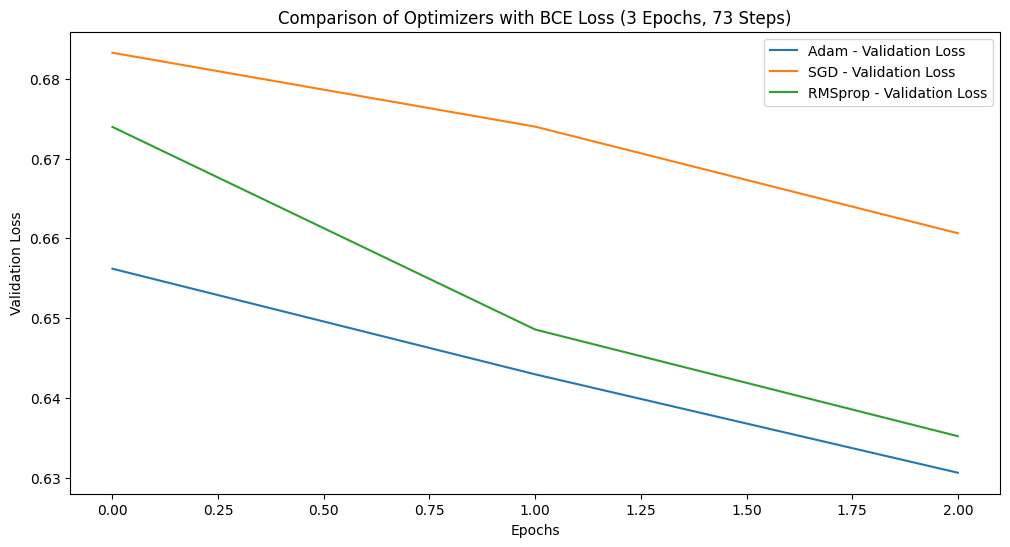

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random
import matplotlib.pyplot as plt

# Define paths
data_dir = "cv_p3_images_split"
train_gray_dir = os.path.join(data_dir, "train/grayscale")
train_color_dir = os.path.join(data_dir, "train/colored")
val_gray_dir = os.path.join(data_dir, "validation/grayscale")
val_color_dir = os.path.join(data_dir, "validation/colored")

# Image dimensions
IMG_HEIGHT, IMG_WIDTH = 256, 256  # Resize all images to 256x256

# Utility to preprocess images
def preprocess_image(image_path, target_size):
    image = load_img(image_path, target_size=target_size, color_mode="rgb")
    image = img_to_array(image) / 255.0  # Normalize to [0, 1]
    return image

def load_dataset(gray_folder, color_folder, target_size, fraction=1.0):
    gray_images = []
    color_images = []
    
    filenames = os.listdir(gray_folder)
    if fraction < 1.0:
        filenames = random.sample(filenames, int(len(filenames) * fraction))  # Sample fraction of filenames
    
    for filename in filenames:
        gray_path = os.path.join(gray_folder, filename)
        color_path = os.path.join(color_folder, filename)
        gray_images.append(preprocess_image(gray_path, target_size)[..., 0:1])  # Extract grayscale channel
        color_images.append(preprocess_image(color_path, target_size))
    
    return np.array(gray_images), np.array(color_images)

# Load training and validation datasets
train_gray, train_color = load_dataset(train_gray_dir, train_color_dir, (IMG_HEIGHT, IMG_WIDTH), 0.25)
val_gray, val_color = load_dataset(val_gray_dir, val_color_dir, (IMG_HEIGHT, IMG_WIDTH), 0.25)

# Define the colorization model
def build_model():
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))

    # Encoder
    x = Conv2D(32, (3, 3), padding="same", strides=2)(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(64, (3, 3), padding="same", strides=2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), padding="same")(x)
    outputs = Activation("sigmoid")(x)

    return Model(inputs, outputs)

# List of optimizers to test
optimizers = {
    "Adam": tf.keras.optimizers.Adam(learning_rate=0.001),
    "SGD": tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    "RMSprop": tf.keras.optimizers.RMSprop(learning_rate=0.001)
}

# Train the BCE model with each optimizer
results = {}

for optimizer_name, optimizer in optimizers.items():
    print(f"\nTraining with {optimizer_name} optimizer...")
    
    # Build and compile the model
    model_bce = build_model()
    model_bce.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    
    # Train the model for 3 epochs with 73 steps per epoch
    history = model_bce.fit(
        train_gray, train_color,
        validation_data=(val_gray, val_color),
        epochs=3,  # Set to 3 epochs
        steps_per_epoch=73,  # Limit to 73 steps per epoch
        verbose=1
    )
    
    # Save the model and history
    model_bce.save(f"colorization_model_bce_{optimizer_name}.h5")
    results[optimizer_name] = history.history

# Plot results
plt.figure(figsize=(12, 6))
for optimizer_name, history in results.items():
    plt.plot(history["val_loss"], label=f"{optimizer_name} - Validation Loss")

plt.title("Comparison of Optimizers with BCE Loss (3 Epochs, 73 Steps)")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()